CIS 4567 - Big Data Analytics

Allen Yang


The project aims at building a model of housing prices to predict median house values in California with obtained dataset. By being able to predict median housing price with given metrics, an investor will be able to decide whether housing prices are undervalued thus provides a buying opportunity or overvalued thus provides a selling opportunity.

The dataset used is California Census Data published by the US Census Bureau which has 10 types of metrics for each block group in California. Districts or block groups are the smallest geographical units for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). There are 20,640 districts in the project dataset.

Dataset Details

Columns for independent variables:
longitude (the longitude of the district)
latitude (the latitude of the district)
housing_median_age (the median age of the houses in the district)
total_rooms (total number of rooms in the district)
total_bedrooms (total number of bedrooms in the district)
population (population of the district)
households (total number of households in the district)
median_income (the median income of the district)
ocean_proximity (proximity to the ocean)

Columns for dependent variables:
median_house_value (the median house value in the district)




In [1]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import pyspark.ml.regression as rg
import pyspark.ml.feature as feat
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd
import pyspark.ml.tuning as tune
import pyspark.ml.evaluation as ev


#set plotting backend to matplotlib instead of plotly
ps.set_option('plotting.backend', 'matplotlib')


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1715577679324_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1715577679324_0001/container_1715577679324_0001_01_000001/pyspark.zip/pyspark/pandas/__init__.py:51: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.

In [2]:
# read csv file from s3
sample_data_csv = ps.read_csv('s3://allenyang/1553768847-housing.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1715577679324_0001/container_1715577679324_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.

In [3]:
# display the head of the dataframe created from csv
sample_data_csv.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income ocean_proximity  median_house_value
0    -122.23     37.88                  41          880             129         322         126         8.3252        NEAR BAY              452600
1    -122.22     37.86                  21         7099            1106        2401        1138         8.3014        NEAR BAY              358500
2    -122.24     37.85                  52         1467             190         496         177         7.2574        NEAR BAY              352100
3    -122.25     37.85                  52         1274             235         558         219         5.6431        NEAR BAY              341300
4    -122.25     37.85                  52         1627             280         565         259         3.8462        NEAR BAY              342200

In [4]:
# display information of the dataset
sample_data_csv.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int32  
 3   total_rooms         20640 non-null  int32  
 4   total_bedrooms      20433 non-null  int32  
 5   population          20640 non-null  int32  
 6   households          20640 non-null  int32  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int32  
dtypes: float64(3), int32(6), object(1)

# Data Preprocessing

In [5]:
# do we have any rows that are duplicated?
print(sample_data_csv.shape[0], sample_data_csv.to_spark().distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20640 20640
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [3]:
# there are no duplicates. however, if we use a different dataset, we may have duplicates
# remove the duplicated rows
full_removed = sample_data_csv.drop_duplicates()
full_removed.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(20640, 10)

In [4]:
# are there missiong values
full_removed.isna().sum()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [5]:
# there are 207 rows with missing values.
# removes records that have missing values.
full_removed = full_removed.dropna()
full_removed.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(20433, 10)

In [9]:
# Generate descriptive statistics and clearly interpret the results. 
#describe numeric features
descriptive_stats = full_removed.describe()
descriptive_stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          longitude      latitude  housing_median_age   total_rooms  total_bedrooms    population    households  median_income  median_house_value
count  20433.000000  20433.000000        20433.000000  20433.000000    20433.000000  20433.000000  20433.000000   20433.000000        20433.000000
mean    -119.570689     35.633221           28.633094   2636.504233      537.870553   1424.946949    499.433465       3.871162       206864.413155
std        2.003578      2.136348           12.591805   2185.269567      421.385070   1133.208490    382.299226       1.899291       115435.667099
min     -124.350000     32.540000            1.000000      2.000000        1.000000      3.000000      1.000000       0.499900        14999.000000
25%     -121.800000     33.930000           18.000000   1450.000000      296.000000    787.000000    280.000000       2.563700       119500.000000
50%     -118.490000     34.260000           29.000000   2126.000000      435.000000   1166.000000    409.000000       

In [10]:
# total_rooms the mean is 2635, the min is 2 and max is 39320.
# total_bedrooms the mean is 537, the min is 1 and max is 6445. 
# population the mean is 1425, the min is 3 and max is 35682.
# households the mean is 499, the min is 1 and max is 6082.
# median_income the mean is 3.87 and the min is 0.49 and the max is 15

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

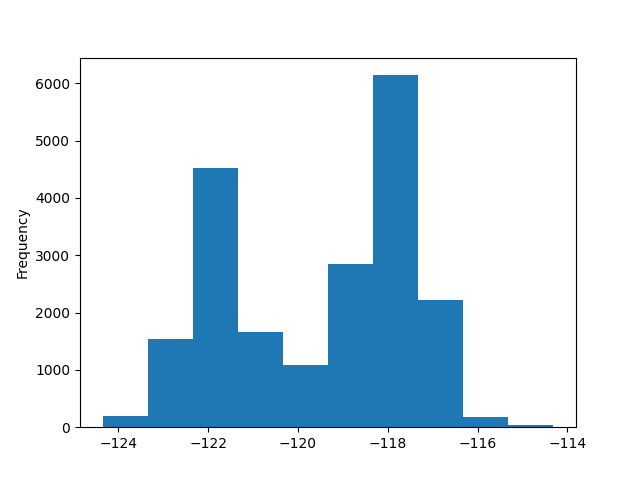

In [11]:
#clear the canvas
plt.clf()
# plot histogram for 'longitude' column
full_removed['longitude'].hist()
%matplot plt

In [12]:
# the 'longitude' histogram shows two peaks (bimodal) around -122 and -118 which is expected as 
# they correspond to los angeles and san franscisco

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

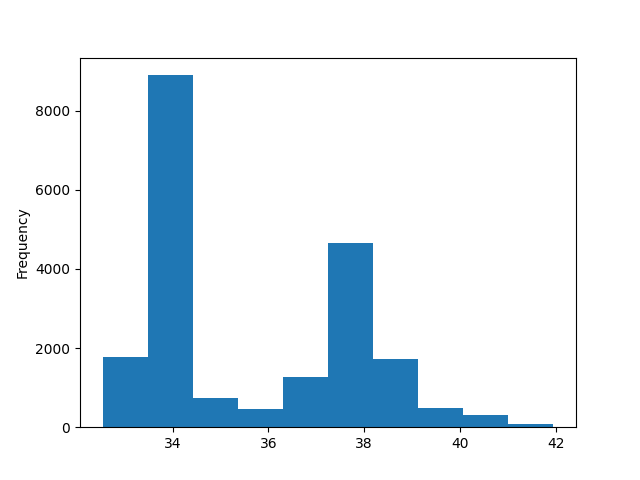

In [13]:
#clear the canvas
plt.clf()
# plot histogram for 'latitude' column
full_removed['latitude'].hist()
%matplot plt

In [14]:
# the 'latitude' histogram shows two peaks which is expected as 
# they correspond to los angeles (34) and san franscisco (38)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

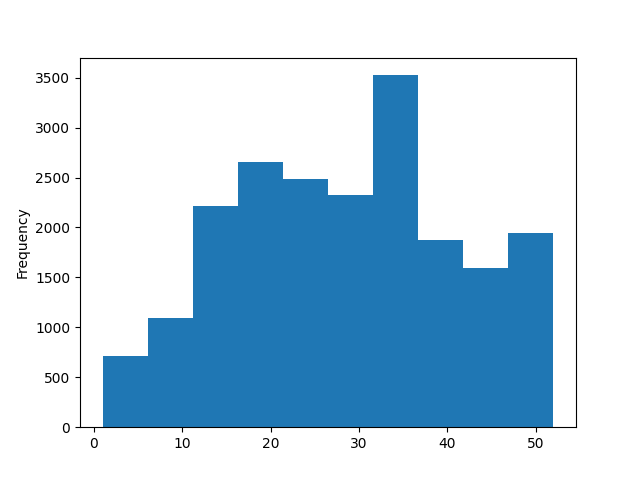

In [15]:
#clear the canvas
plt.clf()
# plot histogram for 'housing_median_age' column
full_removed['housing_median_age'].hist()
%matplot plt

In [16]:
# the 'housing_median_age' peaks at 35 years. the distribution is relatively normal although there are noticable dips
# around 35 and 45

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

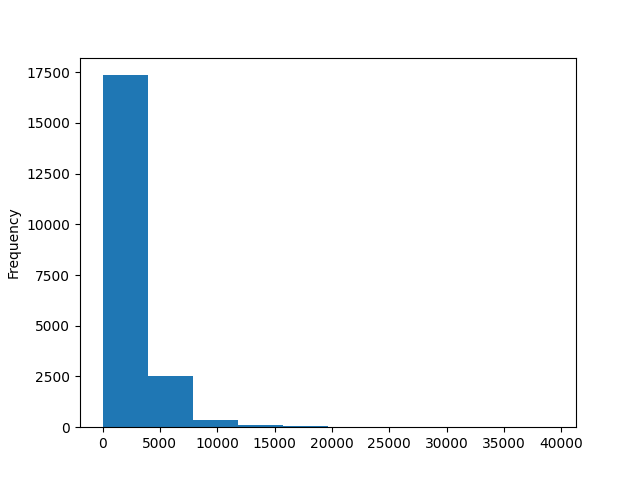

In [17]:
#clear the canvas
plt.clf()
# plot histogram for 'total_rooms' column
full_removed['total_rooms'].hist()
%matplot plt

In [18]:
# 'total_rooms' mostly concentrates around 3000
#  strongly skewed to the right. the mean is 2635 whereas the min is 2 and max is 39320. there are outliers.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

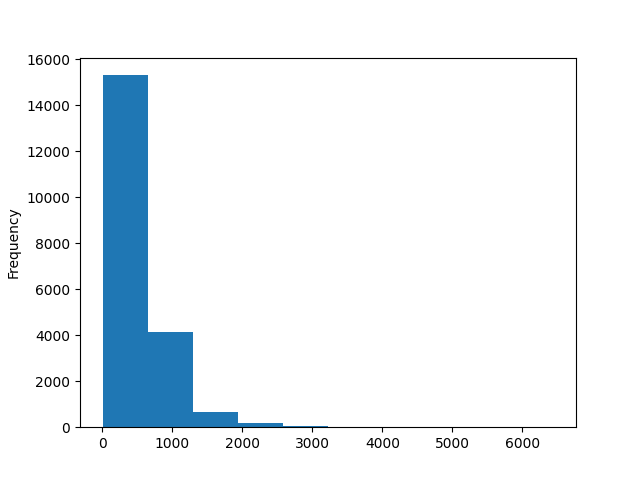

In [19]:
#clear the canvas
plt.clf()
# plot histogram for 'total_bedrooms' column
full_removed['total_bedrooms'].hist()
%matplot plt

In [20]:
# total_bedrooms is skew to right. the mean is 537 whereas the min is 1 and max is 6445. there are outliers.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

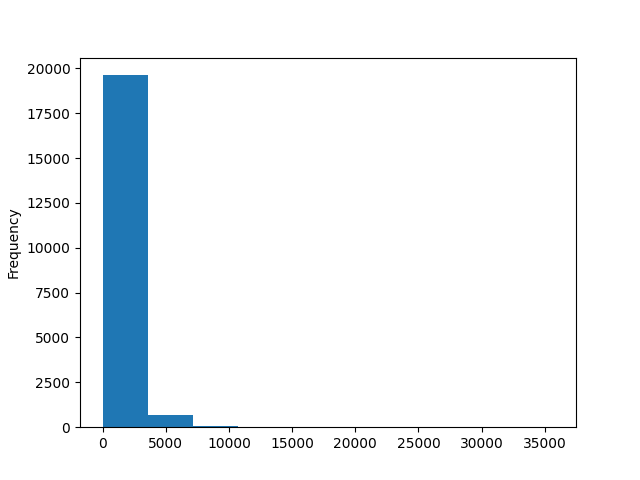

In [21]:
#clear the canvas
plt.clf()
# plot histogram for 'population' column
full_removed['population'].hist()
%matplot plt

In [22]:
# population is skewed to the right. the mean is 1425 whereas the min is 3 and max is 35682. there are outliers.


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

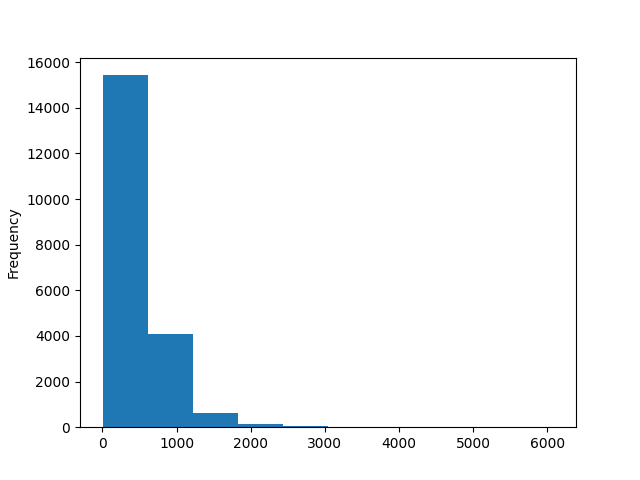

In [23]:
#clear the canvas
plt.clf()
# plot histogram for 'households' column
full_removed['households'].hist()
%matplot plt

In [24]:
# households is skewed to the right. the mean is 499 whereas the min is 1 and max is 6082. there are outliers.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

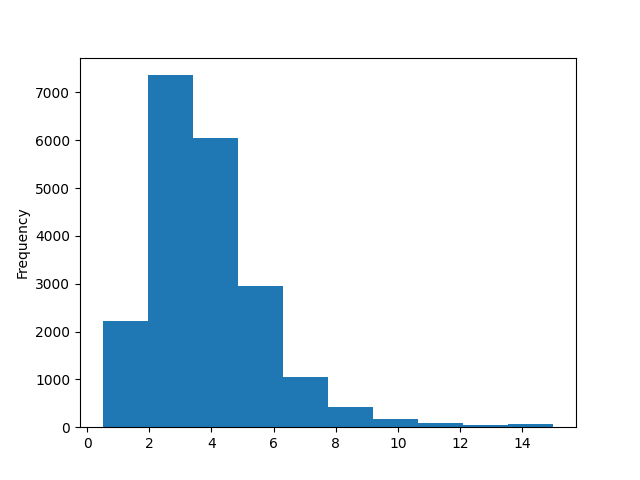

In [25]:
#clear the canvas
plt.clf()
# plot histogram for 'median_income' column
full_removed['median_income'].hist()
%matplot plt

In [26]:
# median_income is normal but shewed to the right. the mean is 3.87 and the min is 0.49 and the max is 15.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

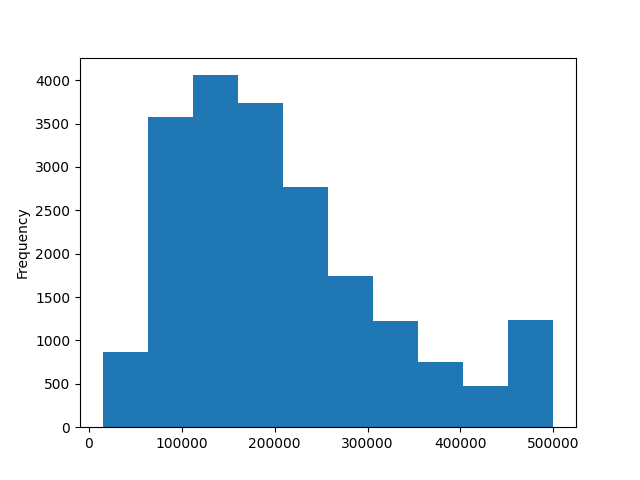

In [27]:
#clear the canvas
plt.clf()
# plot histogram for 'median_house_value' column
full_removed['median_house_value'].hist()
%matplot plt

In [28]:
# median_house_value is normal except the small peak in the far right 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

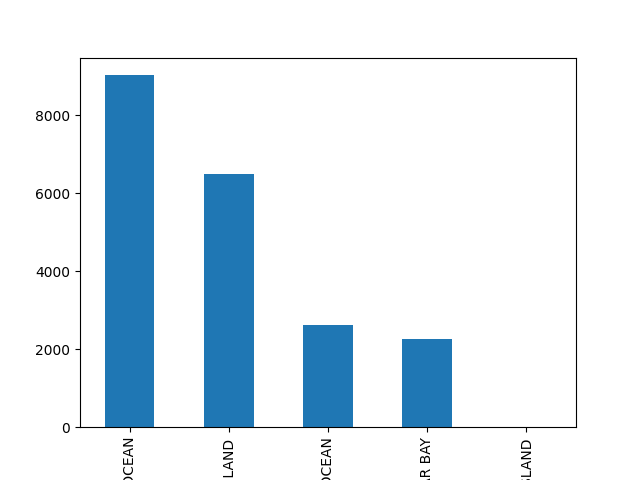

In [29]:
#clear the canvas
plt.clf()
# plot bar chart for 'ocean_proximity' column
full_removed['ocean_proximity'].value_counts().plot(kind='bar')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

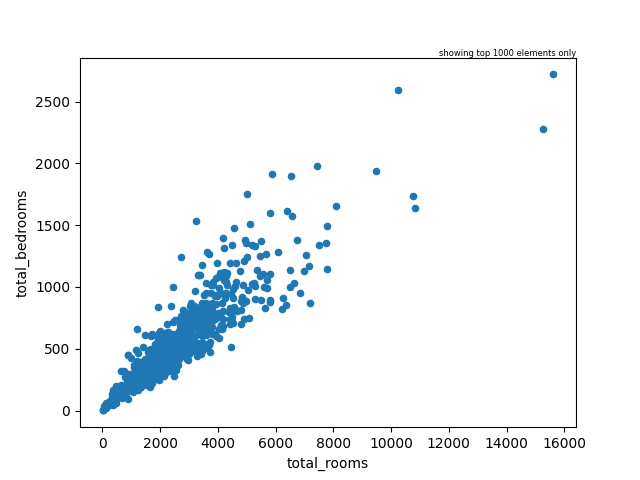

In [30]:
# majority of districts are within 1 hour from the ocean and inland.

#clear the canvas
plt.clf()
# draw a scatter plot for 'total_rooms' vs 'total_bedrooms' as they are likely related to each other
full_removed.plot.scatter(x='total_rooms', y='total_bedrooms')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

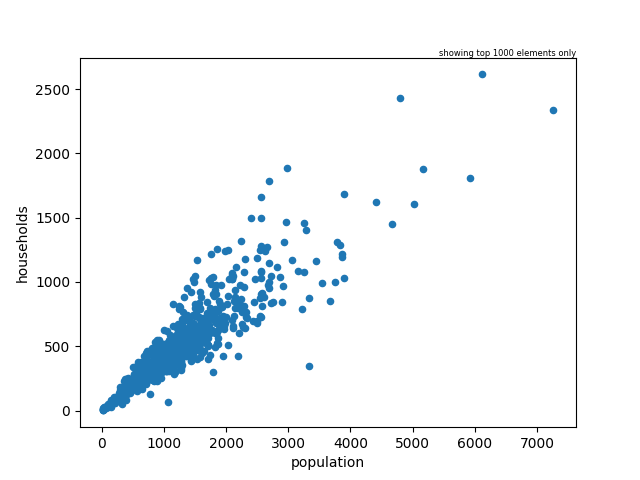

In [31]:
# there seems to be a correlation between 'total_rooms' and 'total_bedrooms' 

#clear the canvas
plt.clf()
# draw a scatter plot for 'population' vs'households' as they are likely related to each other
full_removed.plot.scatter(x='population', y='households')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

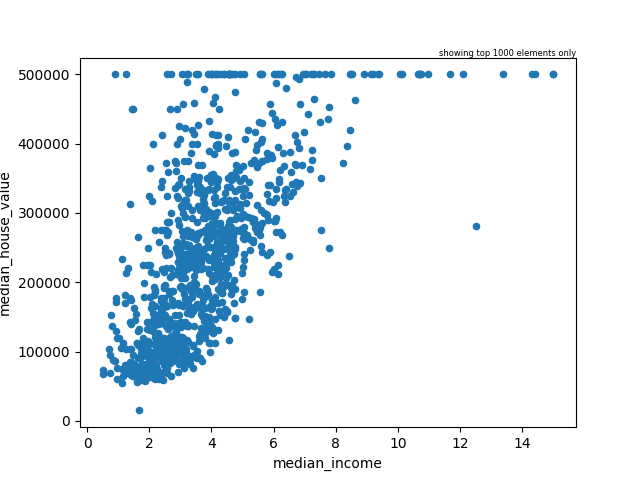

In [32]:
# there seems to be a correlation between 'population' and'households' 

#clear the canvas
plt.clf()
# draw a scatter plot for 'median_income' vs 'median_house_value' as they are very likely related to each other
full_removed.plot.scatter(x='median_income', y='median_house_value')
%matplot plt

In [33]:
# it seems that 'median_income' and 'median_house_value' are somewhat correlated. 
# also 'median_house_value' seems to be capped at 500,000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

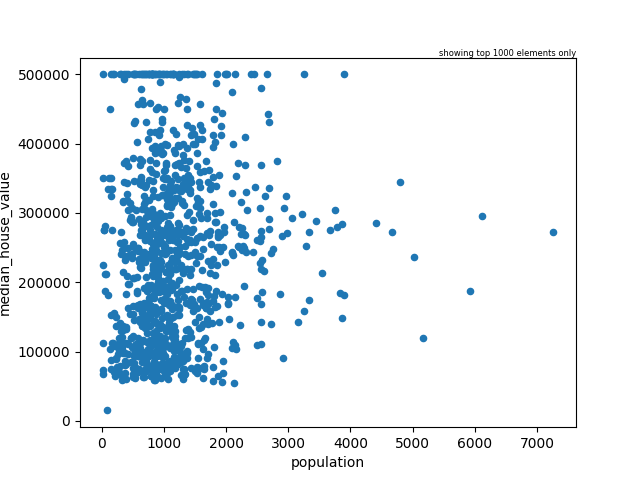

In [34]:
#clear the canvas
plt.clf()
# draw a scatter plot for 'population' vs 'median_house_value' 
full_removed.plot.scatter(x='population', y='median_house_value')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

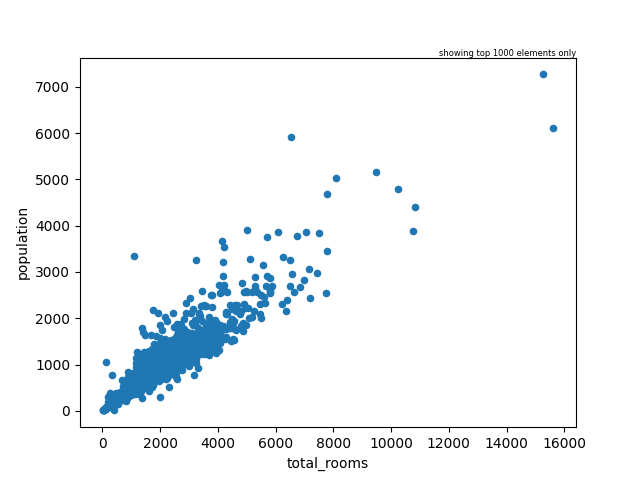

In [35]:
# it seems that population and median_house_value are not correlated

#clear the canvas
plt.clf()
# draw a scatter plot for 'total_rooms' vs 'population' as they likely are related to each other
full_removed.plot.scatter(x='total_rooms', y='population')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

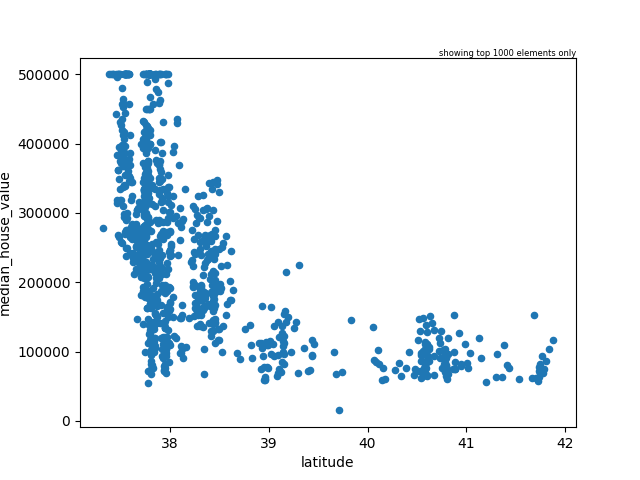

In [36]:
# it appears that total_rooms and population are positively correlated

#clear the canvas
plt.clf()
# draw a scatter plot for 'latitude' vs 'median_house_value'
full_removed.plot.scatter(x='latitude', y='median_house_value')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

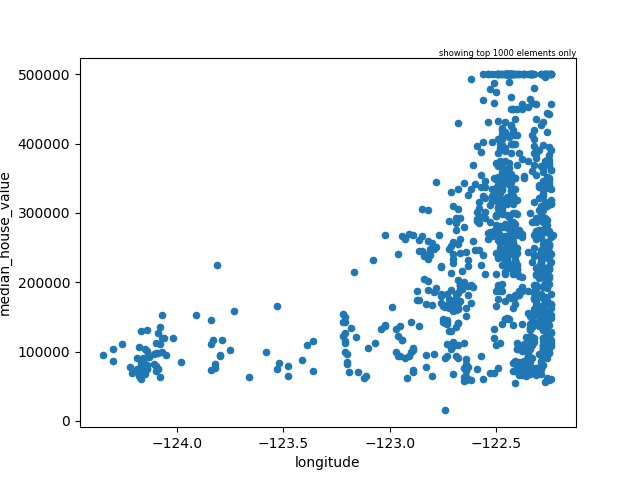

In [37]:
# it seems that 'latitude' and 'median_house_value' are not correlated 

#clear the canvas
plt.clf()
# draw a scatter plot for 'longitude' vs 'median_house_value' 
full_removed.plot.scatter(x='longitude', y='median_house_value')
%matplot plt

In [38]:
# it seeams that 'longitude' and 'median_house_value' are not correlated 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# remove outliears

no_outliers = full_removed

# for the columns
#          longitude      latitude  housing_median_age   total_rooms  total_bedrooms    population    households  median_income  median_house_value
#mean    -119.569704     35.631861           28.639486   2635.763081      537.870553   1425.476744    499.539680       3.870671       206855.816909
#std        2.003532      2.135952           12.585558   2181.615252      421.385070   1132.462122    382.329753       1.899822       115395.615874
#min     -124.350000     32.540000            1.000000      2.000000        1.000000      3.000000      1.000000       0.499900        14999.000000
#max     -114.310000     41.950000           52.000000  39320.000000     6445.000000  35682.000000   6082.000000      15.000100       500001.000000
# we will remove outliers that are three std from the mean for 
# housing_median_age   total_rooms  total_bedrooms    population    households  median_income  median_house_value
#
# for longitude
# -119 + 3*2 = -113
# -119 - 3*2 = -125
# there is no logitude falls outside the above values
#
# for latitude
# 35.6 + 3*2.13 = 41.23
# 35.6 - 3*2.13 = 29.21
# there is no latitude falls outside the above values
#
# for housing_median_age
# 28 + 3*12 = 65
# 28 -3*13 = -8
# there is no housing_median_age falls outside the above values 
#
# for total_rooms mean = 2635, std = 2181: 
# 2635 + 3*2181 = 9,178
# 2635 - 3*2181 = -3,908 
# record the original number of rows
rows = no_outliers.shape[0]
no_outliers = no_outliers[no_outliers.total_rooms < 9178]
# print the percentage of records removed
print((rows-no_outliers.shape[0])/rows)

# for total_bedrooms mean = 537, std = 421 
# 537 + 3*421 = 1800
# 537 - 3*421 = -726
# record the original number of rows
rows = no_outliers.shape[0]
no_outliers = no_outliers[no_outliers.total_bedrooms < 1800]
# print the percentage of records removed
print((rows-no_outliers.shape[0])/rows)

# for population mean = 1425, std = 1132
# 1425 + 3*1132 = 4,821
# 1425 - 3*1132 = -1,971
rows = no_outliers.shape[0]
no_outliers = no_outliers[no_outliers.population < 4821]
# print the percentage of records removed
print((rows-no_outliers.shape[0])/rows)

# for households mean = 499, std = 382
# 499 + 3*382 = 1,645
# 499 - 3*382 = -647
rows = no_outliers.shape[0]
no_outliers = no_outliers[no_outliers.households < 1645]
# print the percentage of records removed
print((rows-no_outliers.shape[0])/rows)

# for median_income mean = 3.87, std = 1.90
# 3.87 + 3*1.90 = 9.57
# 3.87 - 3*1.90 = -1.83
rows = no_outliers.shape[0]
no_outliers = no_outliers[no_outliers.median_income < 9.57]
# print the percentage of records removed
print((rows-no_outliers.shape[0])/rows)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.018205843488474528
0.004984796371068242
0.0038074244777315767
0.00045260246416897157
0.016502314348963574

In [40]:
# as one can see in each step that less than 2 percent rows are removed.

descriptive_stats = no_outliers.describe()
descriptive_stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          longitude      latitude  housing_median_age   total_rooms  total_bedrooms    population    households  median_income  median_house_value
count  19548.000000  19548.000000        19548.000000  19548.000000    19548.000000  19548.000000  19548.000000   19548.000000        19548.000000
mean    -119.586044     35.652919           29.015449   2390.446900      493.818396   1310.738694    460.262533       3.725705       201838.825200
std        2.002868      2.144897           12.423071   1433.078162      290.955924    771.470862    267.286596       1.602118       110689.617739
min     -124.350000     32.540000            1.000000      2.000000        2.000000      3.000000      2.000000       0.499900        14999.000000
25%     -121.800000     33.930000           19.000000   1431.000000      294.000000    782.000000    278.000000       2.540200       117700.000000
50%     -118.510000     34.270000           29.000000   2082.000000      428.000000   1151.000000    403.000000       

In [41]:
# Before removing outliers std
# longitude      latitude  housing_median_age   total_rooms  total_bedrooms    population    households  median_income  median_house_value
# 2.003532      2.135952           12.585558   2181.615252      421.385070   1132.462122    382.329753       1.899822       115395.615874
# After removing outliers
# 2.002868      2.144897           12.423071   1433.078162      290.955924    771.470862    267.286596       1.602118       110689.617739

# removing the outliers has a small impact on the sample

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

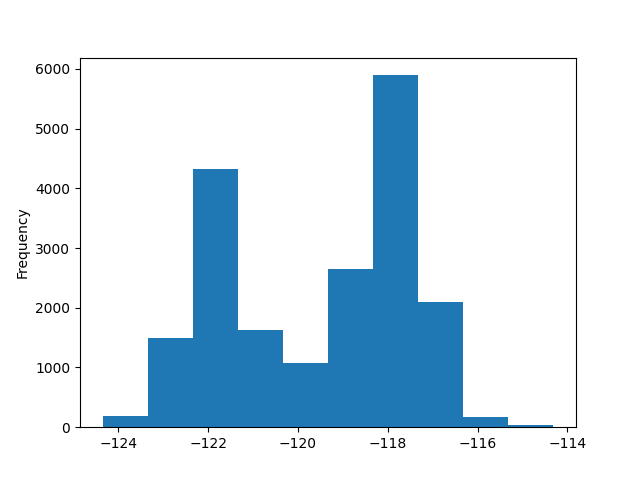

In [42]:
# redo the plots
#clear the canvas
plt.clf()
no_outliers['longitude'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

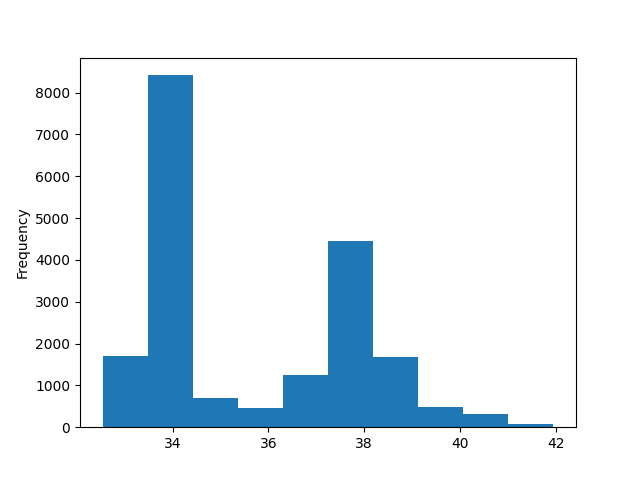

In [43]:
#clear the canvas
plt.clf()
# plot histogram for 'latitude' column
no_outliers['latitude'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

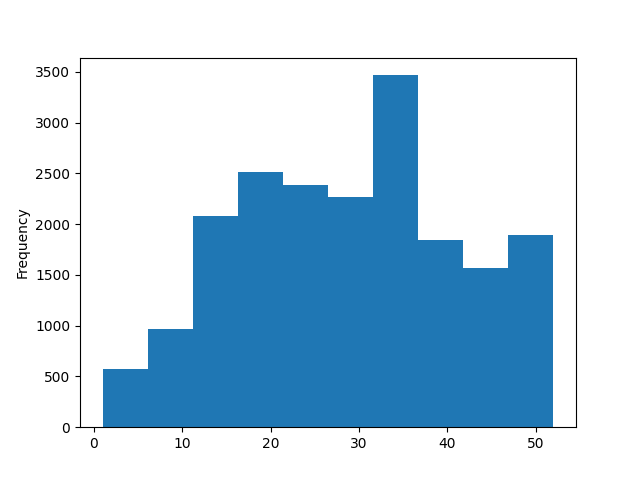

In [44]:
#clear the canvas
plt.clf()
# plot histogram for 'housing_median_age' column
no_outliers['housing_median_age'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

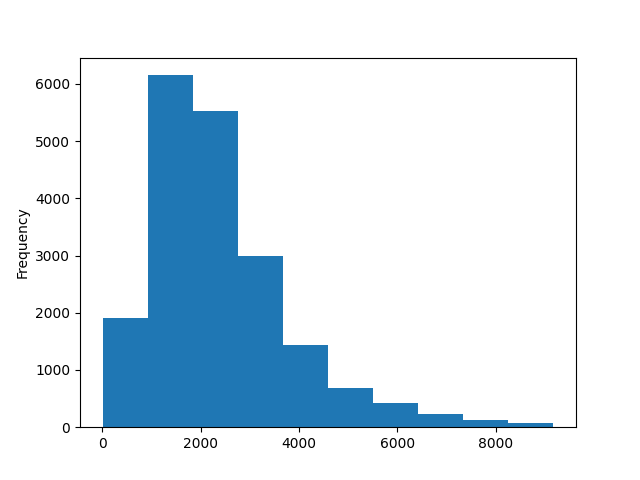

In [45]:
#clear the canvas
plt.clf()
# plot histogram for 'total_rooms' column
no_outliers['total_rooms'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

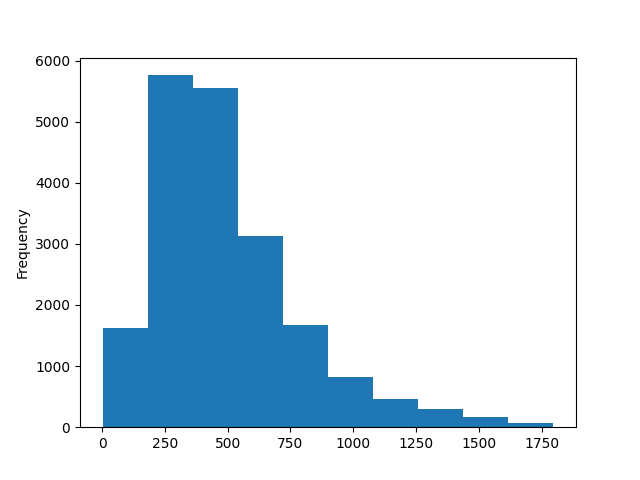

In [46]:
#clear the canvas
plt.clf()
# plot histogram for 'total_bedrooms' column
no_outliers['total_bedrooms'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

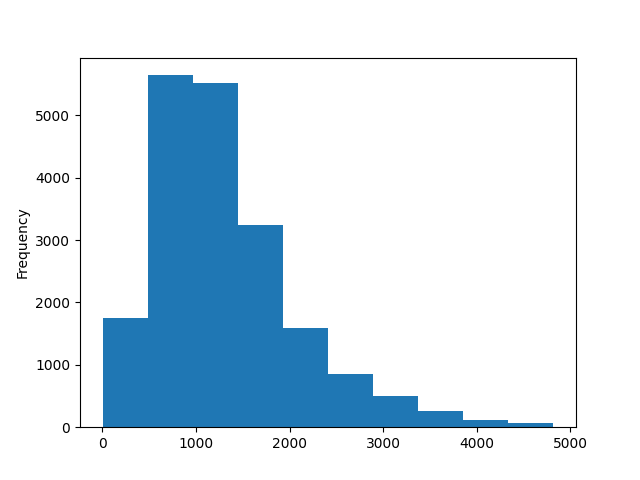

In [47]:
#clear the canvas
plt.clf()
# plot histogram for 'population' column
no_outliers['population'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

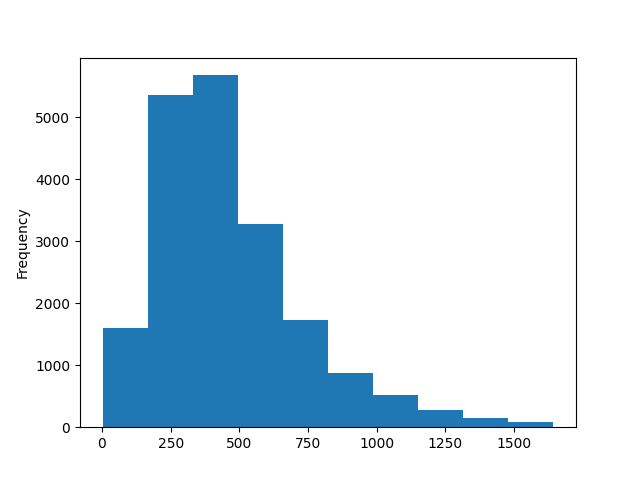

In [48]:
#clear the canvas
plt.clf()
# plot histogram for 'households' column
no_outliers['households'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

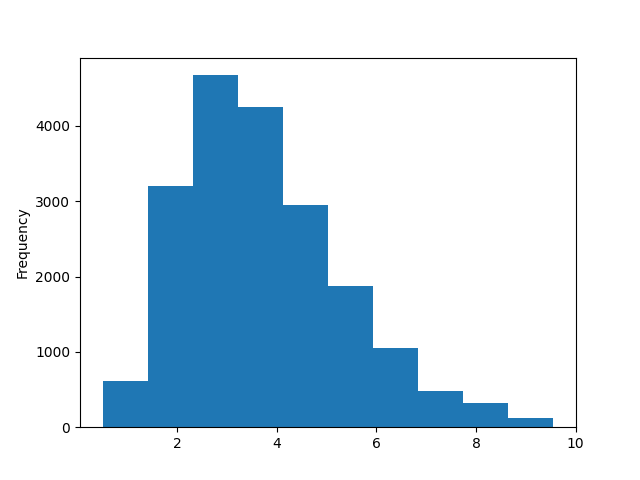

In [49]:
#clear the canvas
plt.clf()
# plot histogram for 'median_income' column
no_outliers['median_income'].hist()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

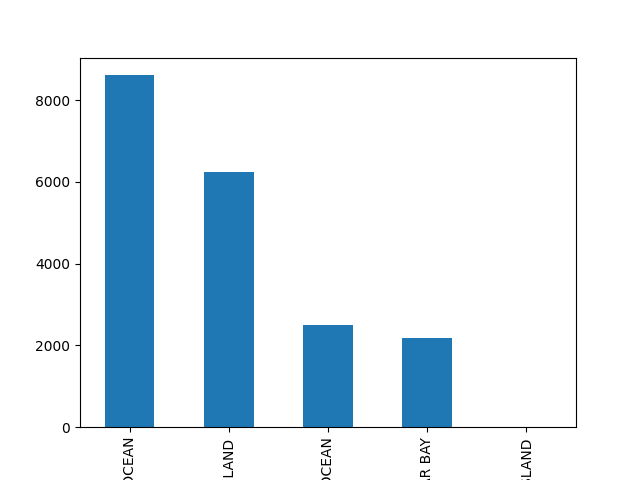

In [50]:
#clear the canvas
plt.clf()
# plot bar chart for 'ocean_proximity' column
no_outliers['ocean_proximity'].value_counts().plot(kind='bar')
%matplot plt

# Correlation matrix

In [51]:
import pyspark.ml.stat as st

# first drop the category 'ocean_proximity' column
df = no_outliers.drop('ocean_proximity', axis=1)

df.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 19548 entries, 2655 to 13924
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19548 non-null  float64
 1   latitude            19548 non-null  float64
 2   housing_median_age  19548 non-null  int32  
 3   total_rooms         19548 non-null  int32  
 4   total_bedrooms      19548 non-null  int32  
 5   population          19548 non-null  int32  
 6   households          19548 non-null  int32  
 7   median_income       19548 non-null  float64
 8   median_house_value  19548 non-null  int32  
dtypes: float64(3), int32(6)

In [52]:
# create a VectorAssembler to vectorize the dataframe.
features_and_label = feat.VectorAssembler(
    inputCols=list(df.columns)
    , outputCol='features', handleInvalid="skip")



corr = st.Correlation.corr(
    features_and_label.transform(df.to_spark()), 
    'features', 
    'pearson'
)

print(str(corr.collect()[0][0]))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseMatrix([[ 1.        , -0.92439281, -0.10003819,  0.0088122 ,  0.04506504,
               0.10481335,  0.0357422 , -0.01545294, -0.04521902],
             [-0.92439281,  1.        ,  0.00186025, -0.00968841, -0.05533637,
              -0.12729853, -0.06705043, -0.08238102, -0.14695742],
             [-0.10003819,  0.00186025,  1.        , -0.34705647, -0.28735689,
              -0.26156848, -0.26349515, -0.1388871 ,  0.11812729],
             [ 0.0088122 , -0.00968841, -0.34705647,  1.        ,  0.90120666,
               0.79827537,  0.89196697,  0.25769691,  0.17068007],
             [ 0.04506504, -0.05533637, -0.28735689,  0.90120666,  1.        ,
               0.84236739,  0.9738068 , -0.01980162,  0.07581181],
             [ 0.10481335, -0.12729853, -0.26156848,  0.79827537,  0.84236739,
               1.        ,  0.87974703, -0.00734337, -0.03487113],
             [ 0.0357422 , -0.06705043, -0.26349515,  0.89196697,  0.9738068 ,
               0.87974703,  1.        ,  0.01

In [53]:
# the correlation matrix shows the following correlations 
#                    longitude        latitude  housing_median_age   total_rooms   total_bedrooms      population      households    median_income  median_house_value
#longitude                     strong negative                  no            no               no              no              no               no                  no
#latitude                                                       no            no               no              no              no               no                  no 
#housing_median_age                                                 weak negative   weak negative              no              no               no                  no
#total_rooms                                                                     strong positive  strong positive strong positive               no                  no    
#total_bedrooms                                                                                   strong positive strong positive               no                  no     
#population                                                                                                       strong positive               no                  no      
#households                                                                                                                                     no                  no            
#median_income                                                                                                                                       moderate positive 
#median_house_value

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Create Dummies

In [7]:
# create dummies for the ocean_proximity column. since we are going to do regression, we are dropping
# the first dummy column
dummies = ps.get_dummies(no_outliers, columns=["ocean_proximity"], drop_first=True)
dummies.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value  ocean_proximity_INLAND  ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN
2655    -124.35     40.54                  52         1820             300         806         270         3.0147               94600                       0                       0                         0                           1
1851    -124.30     41.80                  19         2672             552        1298         478         1.9797               85800                       0                       0                         0                           1
1861    -124.30     41.84                  17         2677             531        1244         456         3.0313              103600                       0                       0                         0                           1
2653    -124.26     40.58                  52         22

# Linear Regression

In [55]:
# create a VectorAssembler to vectorize the dataframe.
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
# create a Linear Regression object to be used to fit the data

# setting ElasticNetParam to 1.0 and regParam to 0.01
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
# create a pipeline to execute both vectorAssembler and lr_obj
pip = Pipeline(stages=[vectorAssembler, lr_obj])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
# run the pipeline
pModel = pip.fit(dummies.to_spark())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [59]:
#get the trained model from the pipeline
lr_model = pModel.stages[-1]
#examine model coefficients
lr_model.coefficients

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([-9967.7114, -9736.2515, 1190.6429, -1.5985, 106.3792, -60.1267, 91.743, 42527.681, -58890.8228, 144730.7691, -2565.2155, 3890.3599])

In [60]:
#print model performance metrics
summary = lr_model.summary

print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.6275740155670695 67548.50882470298 49389.76560288677

In [61]:
# r2 = 0.63
#Evaluating linear Regression model
results = (pModel.transform(dummies.to_spark()).select('median_house_value', 'prediction'))

evaluator = ev.RegressionEvaluator(labelCol='median_house_value')
print(evaluator.evaluate(results, {evaluator.metricName: 'r2'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.6275740155670694

In [62]:
#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   median_house_value     prediction
0               94600  214520.947358
1               85800  133393.342558
2              103600  174331.254304
3              111400  197642.989590
4               78300  149474.127563

# Gradient Boosted Trees Regression

In [63]:
# create a VectorAssembler to vectorize the dataframe.
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# Gradient Boosted Trees regression

gbt_obj = rg.GBTRegressor(
    labelCol='median_house_value'
    , minInstancesPerNode=10
    , minInfoGain=0.1
)

# create a pipline to execute vectorAssembler and gbt_obj
pip = Pipeline(stages=[vectorAssembler, gbt_obj])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
# run the pipeline
pModel = pip.fit(dummies.to_spark())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [65]:
#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   median_house_value     prediction
0               94600  102221.075309
1               85800   98334.823109
2              103600  118546.362310
3              111400   87536.363664
4               78300  118993.480255

there is improvement over the linear regression

In [66]:
#Evaluating the Gradient Boosted Regression model
results = (pModel.transform(dummies.to_spark()).select('median_house_value', 'prediction'))

evaluator = ev.RegressionEvaluator(labelCol='median_house_value')
print(evaluator.evaluate(results, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'rmse'}))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7523284588084667
55085.060691530634
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [67]:
# r2 = 0.75, rootMeanSquareError = 55085

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Tune the hyperparameters

In [68]:
# here we try to tune the hyperparameters for Linear Regression model

# first we test a few values for numTopFeatures to find out which gives a better model

# create a UnivariateFeatureSelector

# featureType categorical and labelType categorical, Spark uses chi-squared, i.e. chi2 in sklearn.
# featureType continuous and labelType categorical, Spark uses ANOVA F-test, i.e. f_classif in sklearn.
# featureType continuous and labelType continuous, Spark uses F-value, i.e. f_regression in sklearn.

# we are going to set FeatureType=continuous and LabelType=continuous to use F-value

# select top 10 features since we have total of 12 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(10) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
     maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]

# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)

#Evaluating the Linear Regression model
#print model performance metrics

print(
    lr_model.summary.r2
    , lr_model.summary.rootMeanSquaredError
    , lr_model.summary.meanAbsoluteError
)

#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
0.5923175849126603 70673.5274746736 52132.32141151762
   median_house_value     prediction
0               94600  202137.523596
1               85800  106986.571566
2              103600  150491.922241
3              111400  174003.215224
4               78300  120300.560358

In [69]:
# select top 9 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(9) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
     maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]

# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)

#Evaluating the Linear Regression model
#print model performance metrics

print(
    lr_model.summary.r2
    , lr_model.summary.rootMeanSquaredError
    , lr_model.summary.meanAbsoluteError
)

#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
0.5907137199654654 70812.40951192752 51783.2544606884
   median_house_value     prediction
0               94600  222391.418465
1               85800  146441.877392
2              103600  191166.422830
3              111400  195782.131425
4               78300  159512.821954
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [70]:
# select top 8 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(8) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
     maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]

# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)

#Evaluating the Linear Regression model
#print model performance metrics

print(
    lr_model.summary.r2
    , lr_model.summary.rootMeanSquaredError
    , lr_model.summary.meanAbsoluteError
)

#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY']
0.587235225721751 71112.6876033541 52288.053757614354
   median_house_value     prediction
0               94600  215783.297018
1               85800  136505.101494
2              103600  179810.339664
3              111400  189993.797061
4               78300  150538.558537
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [71]:
# select top 7 features

selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(7) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
     maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]

# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)

#Evaluating the Linear Regression model
#print model performance metrics

print(
    lr_model.summary.r2
    , lr_model.summary.rootMeanSquaredError
    , lr_model.summary.meanAbsoluteError
)

#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND']
0.5879862703108139 71047.96173569189 52023.35593633923
   median_house_value     prediction
0               94600  207162.037716
1               85800  135651.551572
2              103600  179598.363343
3              111400  181010.188542
4               78300  148531.990457
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [72]:
# Now try top 6 features

selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(6) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
     maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]

# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)

#Evaluating the Linear Regression model
#print model performance metrics

print(
    lr_model.summary.r2
    , lr_model.summary.rootMeanSquaredError
    , lr_model.summary.meanAbsoluteError
)

#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income']
0.5369845400222857 75317.08879972424 55896.96558035677
   median_house_value     prediction
0               94600  172525.252661
1               85800   68973.007967
2              103600  118162.697732
3              111400  143463.744106
4               78300   93534.682245
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [73]:
# here is a summary of numTopFeatures tests
# r2, rootMeanSquaredError, meanAbsoluteError
# 10: 0.5923175849126124 70673.52747467773 52132.32141152542
# 9: 0.5907137199654654 70812.40951192752 51783.2544606884
# 8: 0.5872352257217488 71112.6876033543 52288.05375761412
# 7: 0.5879862703108139 71047.96173569189 52023.35593633923
# 6: 0.536984540022285 75317.08879972428 55896.96558035669
# 
# from 7 to 6 there is a larger change in r2 and rootMeanSquaredError.
# it seems keeping 7 features is a good choice
# selected features are
# ['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
# now try to tune regParam and elasticNetParam values

# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")


# create a selector
# select 7 features. we have total of 12 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(7) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
    maxIter=10)


#use ParamGridBuilder to build a grid of parameters
linearReg_grid = (
    tune.ParamGridBuilder()
    #try values for regParam
    .addGrid(lr_obj.regParam
            ,  [0.0, 0.2, 0.4, 0.6, 0.8, 1]
        )
    #try values for elasticNetParam
    .addGrid(lr_obj.elasticNetParam
            ,  [0, 0.5, 1]
        )
    .build()
)

# create an evaluator
evaluator = ev.RegressionEvaluator(labelCol='median_house_value')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=lr_obj
    , estimatorParamMaps=linearReg_grid
    , evaluator=evaluator
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
# create a pipeline for vectorAssembler
pip = Pipeline(stages=[vectorAssembler, selector])

# run the pipeline
pModel = pip.fit(dummies.to_spark())


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [76]:
# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND']

In [77]:
# top 7 features are
# ['latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'households', 'median_income', 'ocean_proximity_INLAND']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
linearReg_modelTest = cross_v.fit(
    pModel.transform(dummies.to_spark())
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-78:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


In [79]:
print('Best params - regParam: {}, elasticNetParam: {}'.format(
    linearReg_modelTest.bestModel._java_obj.getRegParam(),
      linearReg_modelTest.bestModel._java_obj.getElasticNetParam()))

VBox()

Exception in thread cell_monitor-79:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best params - regParam: 1.0, elasticNetParam: 0.0

In [80]:
tuning_results = pd.DataFrame([list(x.values()) for x in linearReg_grid], columns=['regParam', 'elasticNetParam'])
tuning_results['F-1'] = linearReg_modelTest.avgMetrics
tuning_results.sort_values('F-1', ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-80:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


    regParam  elasticNetParam           F-1
4        0.2              0.5  71381.614112
17       1.0              1.0  71366.381742
14       0.8              1.0  71366.354495
16       1.0              0.5  71366.334259
11       0.6              1.0  71366.327269
13       0.8              0.5  71366.316538
8        0.4              1.0  71366.300065
10       0.6              0.5  71207.553846
7        0.4              0.5  71207.547711
5        0.2              1.0  71207.541733
0        0.0              0.0  70677.075320
2        0.0              1.0  70677.075320
1        0.0              0.5  70677.075320
3        0.2              0.0  70677.070939
6        0.4              0.0  70677.066575
9        0.6              0.0  70677.062229
12       0.8              0.0  70677.057901
15       1.0              0.0  70677.053590

In [81]:
# Best params - regParam: 1.0, elasticNetParam: 0.0


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-81:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


In [82]:
# get the best model
lr_model = linearReg_modelTest.bestModel

#print model performance metrics
summary = lr_model.summary
print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.5927061242424883 70639.84195180048 51703.19012813592

Exception in thread cell_monitor-82:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


In [83]:
# redo linear regression with regParam = 1  elasticNetParam = 0.0 obtained for best model
# and only use the top 7 features

# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")


# create a selector
# select 7 features. we have total of 12 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(7) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
    maxIter=10
    , regParam=1
    , elasticNetParam=0.0)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]


#Evaluating the Linear Regression model

#print model performance metrics
summary = lr_model.summary
print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)


VBox()

Exception in thread cell_monitor-83:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


0.5927061242424881 70639.84195180048 51703.19012813592
/mnt/yarn/usercache/livy/appcache/application_1715394311875_0001/container_1715394311875_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [84]:
# r2 = 0.59, rootMeanSquaredError = 70639
# comparing with 
# r2 = 0.585, rootMeanSquaredError = 67548
# when setting regParam to 0.01, ElasticNetParam to 1.0, numTopFeatures = 7, 
# this model is almost the same 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-84:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


In [85]:
#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-85:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


   median_house_value     prediction
0               94600  210480.915348
1               85800  133839.751719
2              103600  180432.094448
3              111400  181246.141457
4               78300  145625.314447

In [87]:
# now try Gradient Boosted Trees regression using top 7 features

# create a VectorAssembler to vectorize the dataframe.
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a selector
# select 7 features. we have total of 12 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(7) 

# Gradient Boosted Trees regression
gbt_obj = rg.GBTRegressor(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , minInfoGain=0.1
)

# create a pipline to execute vectorAssembler and gbt_obj
pip = Pipeline(stages=[vectorAssembler, selector, gbt_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#Evaluating the Gradient Boosted Regression model
results = (pModel.transform(dummies.to_spark()).select('median_house_value', 'prediction'))

evaluator = ev.RegressionEvaluator(labelCol='median_house_value')
print(evaluator.evaluate(results, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'rmse'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-87:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


0.6698467351369093
63599.481802633076

In [88]:
#get predictions from the model
print(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   median_house_value     prediction
0               94600  125668.261948
1               85800   90149.978968
2              103600   99392.023002
3              111400   92000.772284
4               78300   86878.248936

In [ ]:
# r2 = 0.67, rootMeanSquareError = 63,599
# comparing with model obtained with 12 features
# r2 = 0.75, rootMeanSquareError = 55,085
# this model seems to be slightly worse. however only 7 features are needed instead of 12.

In [8]:
# now try to tune regParam and elasticNetParam values using 12 features

# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")


# create a selector
# select 12 features. we have total of 12 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(12) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
    maxIter=10)


#use ParamGridBuilder to build a grid of parameters
linearReg_grid = (
    tune.ParamGridBuilder()
    #try values for regParam
    .addGrid(lr_obj.regParam
            ,  [0.0, 0.2, 0.4, 0.6, 0.8, 1]
        )
    #try values for elasticNetParam
    .addGrid(lr_obj.elasticNetParam
            ,  [0, 0.5, 1]
        )
    .build()
)

# create an evaluator
evaluator = ev.RegressionEvaluator(labelCol='median_house_value')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=lr_obj
    , estimatorParamMaps=linearReg_grid
    , evaluator=evaluator
)


# create a pipeline for vectorAssembler
pip = Pipeline(stages=[vectorAssembler, selector])

# run the pipeline
pModel = pip.fit(dummies.to_spark())


# get the selected features
data_trans_test = pModel.transform(dummies.to_spark())

selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

print(selected_cols)


linearReg_modelTest = cross_v.fit(
    pModel.transform(dummies.to_spark())
)

print('Best params - regParam: {}, elasticNetParam: {}'.format(
    linearReg_modelTest.bestModel._java_obj.getRegParam(),
      linearReg_modelTest.bestModel._java_obj.getElasticNetParam()))


# get the best model
lr_model = linearReg_modelTest.bestModel

#print model performance metrics
summary = lr_model.summary
print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-8:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
Best params - regParam: 1.0, elasticNetParam: 0.0
0.6376765368562181 66626.041089265 48720.58721320185
/mnt/yarn/usercache/livy/appcache/application_1715577679324_0001/container_1715577679324_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

In [9]:
# redo linear regression with regParam = 1  elasticNetParam = 0.0 obtained for best model
# and use 12 features

# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")


# create a selector
# select 12 features. we have total of 12 features
selector = feat.UnivariateFeatureSelector(
    labelCol='median_house_value'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("continuous"
    ).setSelectionThreshold(12) 


# create a Linear Regression object to be used to fit the data
# set the featuresCol obtained from the selector
lr_obj = rg.LinearRegression(
    labelCol='median_house_value',
    featuresCol=selector.getOutputCol(),
    maxIter=10
    , regParam=1
    , elasticNetParam=0.0)


# create a VectorAssembler to vectorize the dataframe. exclude median_house_value column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in dummies.columns if x != 'median_house_value']
    , outputCol='features', handleInvalid="skip")

# create a pipeline for vectorAssembler, selector, linear regression
pip = Pipeline(stages=[vectorAssembler, selector, lr_obj])

# run the pipeline
pModel = pip.fit(dummies.to_spark())

#
lr_model = pModel.stages[-1]


#Evaluating the Linear Regression model

#print model performance metrics
summary = lr_model.summary
print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)


#get predictions from the model
(
    pModel.transform(dummies.to_spark())
    .pandas_api()
    [['median_house_value', 'prediction']]
    .head(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-9:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'


0.637676536856218 66626.041089265 48720.587213201405
   median_house_value     prediction
0               94600  202828.027339
1               85800  101478.990588
2              103600  143518.021082
3              111400  181108.621281
4               78300  120018.746366